In [2]:
import onnx
import sclblonnx as so
import onnx
import numpy as np
import skl2onnx
import cv2
import matplotlib.pyplot as plt
import h5py
import tqdm
import more_itertools

In [3]:
model = so.graph_from_file("webface_r50_pfc.onnx")
cluster = so.graph_from_file("cluster_model.webface_r50_pfc.680.onnx")

In [4]:
node_slice = onnx.helper.make_node(
    'Slice',
    inputs=['680', "680.start", "680.end", "680.axes"],
    outputs=['680.slice.nd'],
    name="Slice.680"
)
node_squeeze = onnx.helper.make_node(
    'Squeeze',
    inputs=['680.slice.nd'],
    axes=[2, 3],
    outputs=['680.slice'],
    name="Squeeze.680"
)

In [5]:
model = so.add_constant(model, "680.start", value=np.asarray([3, 3]), data_type="INT64")
model = so.add_constant(model, "680.end", value=np.asarray([4, 4]), data_type="INT64")
model = so.add_constant(model, "680.axes", value=np.asarray([2, 3]), data_type="INT64")
model = so.add_node(model, node_slice)
model = so.add_node(model, node_squeeze)

In [6]:
model12 = so.merge(model, cluster, io_match=[("680.slice", "float_input")], complete=False)
out0 = onnx.helper.ValueInfoProto()
out0.name = model12.output[0].name
model12.output.remove(model12.output[0])
model12.output.insert(0, out0)

In [7]:
so.graph_to_file(model12, "webface_r50_pfc+cluster.onnx")

True

In [8]:
import onnxruntime as rt

In [9]:
#sess_model = rt.InferenceSession("webface_r50_pfc.onnx", None)
sess_combined = rt.InferenceSession("webface_r50_pfc+cluster.onnx", None)
#sess_cluster = rt.InferenceSession("cluster_model.webface_r50_pfc.680.onnx", None)

/home/mkochurov/.pyenv/versions/dl-tsne-miniconda/lib/python3.8/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:350: UserWarning: Deprecation warning. This ORT build has ['CUDAExecutionProvider', 'CPUExecutionProvider'] enabled. The next release (ORT 1.10) will require explicitly setting the providers parameter (as opposed to the current behavior of providers getting set/registered by default based on the build flags) when instantiating InferenceSession.For example, onnxruntime.InferenceSession(..., providers=["CUDAExecutionProvider"], ...)
  warnings.warn("Deprecation warning. This ORT build has {} enabled. ".format(available_providers) +


In [10]:
def prepare_batch(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    blob = cv2.dnn.blobFromImages(imgs, 1.0 / 127.5, (112, 112),
                                  (127.5, 127.5, 127.5), swapRB=True)
    return blob

def load_img(path):
    img = cv2.imread(root + path)
    assert img is not None, path
    return img

def load_imgs(paths):
    return list(map(load_img, paths))

In [11]:
files = np.asarray(list(map(str.strip, open("../lists/glint360.txt").readlines())))
root = "../data/"

In [12]:
batch = prepare_batch(load_imgs(files[503:504]))

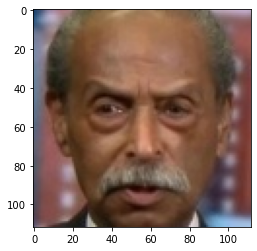

In [13]:
plt.imshow(load_img(files[503])[..., ::-1]);

In [14]:
slc = slice(0, 10)
batch = prepare_batch(load_imgs(files[slc]))

In [15]:
combined_predictions = sess_combined.run(None, {"input.1": batch})

In [ ]:
model_file = "webface_r50_pfc"
with tqdm.tqdm(files) as _files, h5py.File(model_file + f".combined.embeddings.h5", "w") as f:
    facen = f.create_dataset("facen", (0, 512), maxshape=(None, 512), chunks=(512, 512))
    clust = f.create_dataset("cluster", (0,), maxshape=(None,), chunks=(512,))
    for images in more_itertools.chunked(
            map(cv2.imread, map(root.__add__, _files))
        , 512):
        batch = prepare_batch(images)
        facen_i, clust_i, _ = sess_combined.run(None, {"input.1": batch})
        facen.resize((facen.shape[0]+facen_i.shape[0], facen.shape[1]))
        clust.resize((clust.shape[0]+clust_i.shape[0],))
        facen[-facen_i.shape[0]:] = facen_i
        clust[-clust_i.shape[0]:] = clust_i

  0%|          | 9922/17091657 [00:18<9:05:27, 521.94it/s] 

In [42]:
results.close()

In [44]:
results = h5py.File(model_file + f".combined.embeddings.h5", "r")

In [45]:
results_hist = np.unique(results["cluster"], return_counts=True)

In [46]:
results_hist

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       dtype=float32),
 array([ 1623712, 14066454,   773684,   259785,   110246,    19122,
          148261,    27808,    23806,     8573,    30206]))

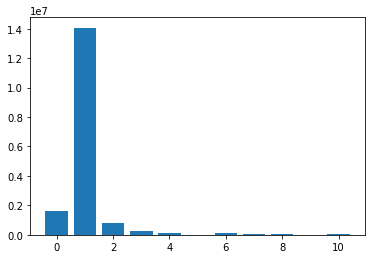

In [47]:
plt.bar(*results_hist);

In [52]:
def get_class(image_files, labels, class_, seed=42, n=100):
    idx, = (labels == class_).nonzero()
    np.random.RandomState(seed).shuffle(idx)
    return load_imgs([image_files[i] for i in idx[:n]])

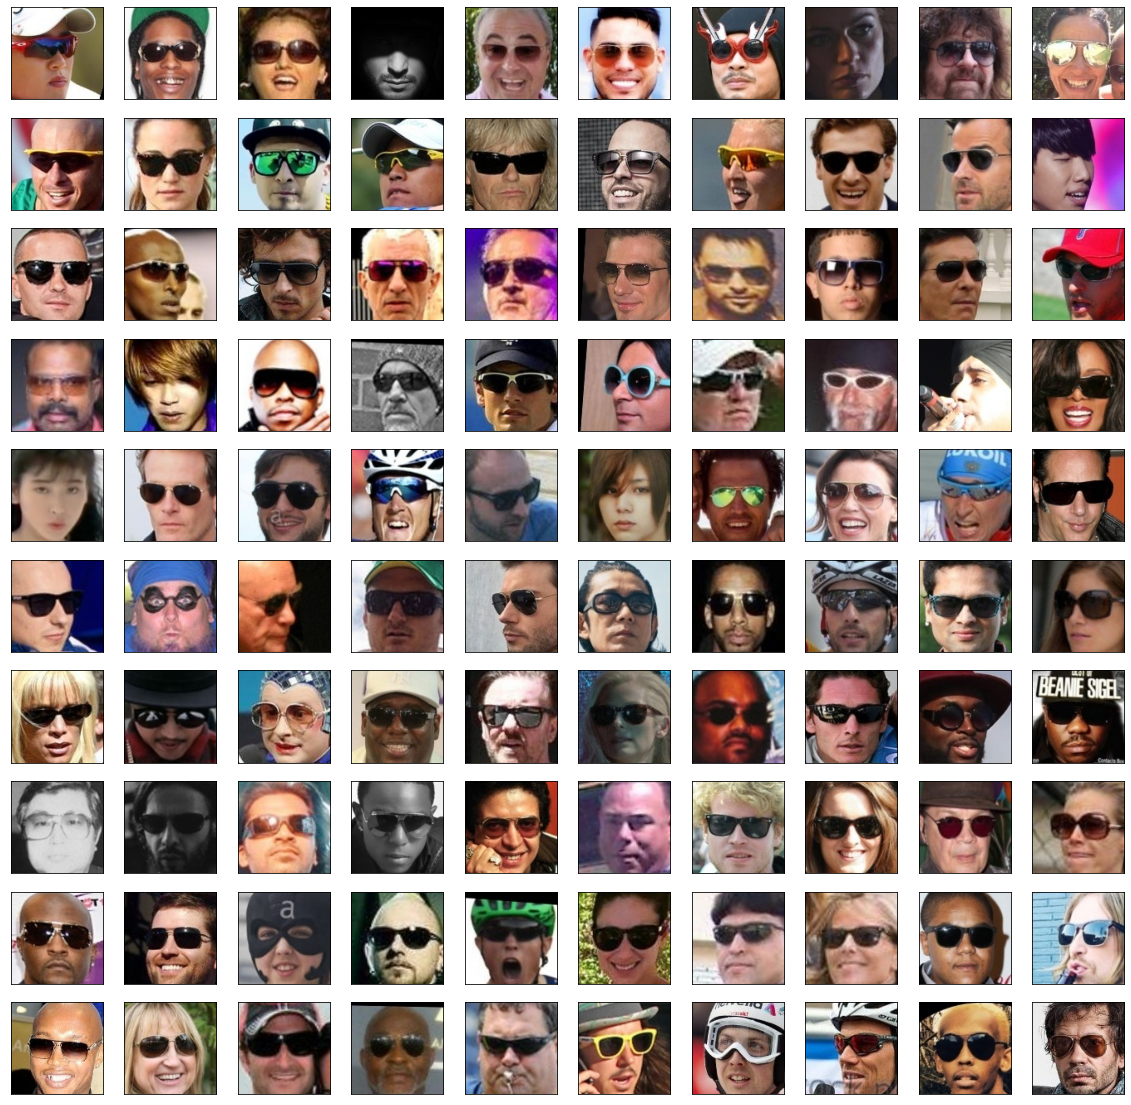

In [57]:
n = 10
C = 3
cls = get_class(files, results["cluster"][()], C, n ** 2)
fig, axes = plt.subplots(n, n, figsize=(n*2, n*2))
for im, ax in zip(cls, axes.flat):
    ax.imshow(im[..., ::-1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)